# Imports

In [58]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf

In [59]:
df=pd.read_parquet("data/fhvhv_tripdata_2023-01.parquet")

In [60]:
df.head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B03404,B03404,2023-01-01 00:18:06,2023-01-01 00:19:24,2023-01-01 00:19:38,2023-01-01 00:48:07,48,68,0.94,...,2.30,2.75,0.0,5.22,27.83,N,N,,N,N
1,HV0003,B03404,B03404,2023-01-01 00:48:42,2023-01-01 00:56:20,2023-01-01 00:58:39,2023-01-01 01:33:08,246,163,2.78,...,5.34,2.75,0.0,0.00,50.15,N,N,,N,N
2,HV0003,B03404,B03404,2023-01-01 00:15:35,2023-01-01 00:20:14,2023-01-01 00:20:27,2023-01-01 00:37:54,9,129,8.81,...,2.16,0.00,0.0,0.00,20.22,N,N,,N,N
3,HV0003,B03404,B03404,2023-01-01 00:35:24,2023-01-01 00:39:30,2023-01-01 00:41:05,2023-01-01 00:48:16,129,129,0.67,...,1.22,0.00,0.0,0.00,7.90,N,N,,N,N
4,HV0003,B03404,B03404,2023-01-01 00:43:15,2023-01-01 00:51:10,2023-01-01 00:52:47,2023-01-01 01:04:51,129,92,4.38,...,1.82,0.00,0.0,0.00,16.48,N,N,,N,N


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18479031 entries, 0 to 18479030
Data columns (total 24 columns):
 #   Column                Dtype         
---  ------                -----         
 0   hvfhs_license_num     object        
 1   dispatching_base_num  object        
 2   originating_base_num  object        
 3   request_datetime      datetime64[us]
 4   on_scene_datetime     datetime64[us]
 5   pickup_datetime       datetime64[us]
 6   dropoff_datetime      datetime64[us]
 7   PULocationID          int64         
 8   DOLocationID          int64         
 9   trip_miles            float64       
 10  trip_time             int64         
 11  base_passenger_fare   float64       
 12  tolls                 float64       
 13  bcf                   float64       
 14  sales_tax             float64       
 15  congestion_surcharge  float64       
 16  airport_fee           float64       
 17  tips                  float64       
 18  driver_pay            float64       
 19

# Data Cleanup / Preprocessing

In [62]:
# Remove Null Values
df.dropna(inplace=True)

In [63]:
# Drop unused column
df.drop(['hvfhs_license_num','dispatching_base_num','originating_base_num','base_passenger_fare','tolls','bcf','sales_tax','congestion_surcharge','airport_fee','tips','driver_pay','shared_match_flag','shared_request_flag','access_a_ride_flag','wav_match_flag','wav_request_flag'],axis=1, inplace=True)

In [64]:
# Cast the start/end station id to numbers
df[['Pickup', 'Drop']] = df[['PULocationID', 'DOLocationID']].apply(pd.to_numeric, errors='coerce')

In [65]:
# Convert to Date/time
df['started_at']=pd.to_datetime(df['request_datetime'])
df['ended_at']=pd.to_datetime(df['dropoff_datetime'])

In [66]:
# Get time of day in terms of percentage
df['start_time'] = (df['started_at'].dt.hour + (df['started_at'].dt.minute / 60)) / 24

# Convert time of day to cyclic features using sine and cosine
df['time_sin'] = np.sin(2 * np.pi * df['start_time'])
df['time_cos'] = np.cos(2 * np.pi * df['start_time'])

In [67]:
# Also consider cyclic day of the week
df['day_sin'] = np.sin(2 * np.pi * df['started_at'].dt.dayofweek / 7)
df['day_cos'] = np.cos(2 * np.pi * df['started_at'].dt.dayofweek / 7)

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13587039 entries, 0 to 18479030
Data columns (total 17 columns):
 #   Column             Dtype         
---  ------             -----         
 0   request_datetime   datetime64[us]
 1   on_scene_datetime  datetime64[us]
 2   pickup_datetime    datetime64[us]
 3   dropoff_datetime   datetime64[us]
 4   PULocationID       int64         
 5   DOLocationID       int64         
 6   trip_miles         float64       
 7   trip_time          int64         
 8   Pickup             int64         
 9   Drop               int64         
 10  started_at         datetime64[us]
 11  ended_at           datetime64[us]
 12  start_time         float64       
 13  time_sin           float64       
 14  time_cos           float64       
 15  day_sin            float64       
 16  day_cos            float64       
dtypes: datetime64[us](6), float64(6), int64(5)
memory usage: 1.8 GB


In [69]:
df.head()

,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,Pickup,Drop,started_at,ended_at,start_time,time_sin,time_cos,day_sin,day_cos
0,2023-01-01 00:18:06,2023-01-01 00:19:24,2023-01-01 00:19:38,2023-01-01 00:48:07,48,68,0.94,1709,48,68,2023-01-01 00:18:06,2023-01-01 00:48:07,0.012500,0.078459,0.996917,-0.781831,0.62349
1,2023-01-01 00:48:42,2023-01-01 00:56:20,2023-01-01 00:58:39,2023-01-01 01:33:08,246,163,2.78,2069,246,163,2023-01-01 00:48:42,2023-01-01 01:33:08,0.033333,0.207912,0.978148,-0.781831,0.62349
2,2023-01-01 00:15:35,2023-01-01 00:20:14,2023-01-01 00:20:27,2023-01-01 00:37:54,9,129,8.81,1047,9,129,2023-01-01 00:15:35,2023-01-01 00:37:54,0.010417,0.065403,0.997859,-0.781831,0.62349
3,2023-01-01 00:35:24,2023-01-01 00:39:30,2023-01-01 00:41:05,2023-01-01 00:48:16,129,129,0.67,431,129,129,2023-01-01 00:35:24,2023-01-01 00:48:16,0.024306,0.152123,0.988362,-0.781831,0.62349
4,2023-01-01 00:43:15,2023-01-01 00:51:10,2023-01-01 00:52:47,2023-01-01 01:04:51,129,92,4.38,724,129,92,2023-01-01 00:43:15,2023-01-01 01:04:51,0.029861,0.186524,0.982450,-0.781831,0.62349


# Visualization

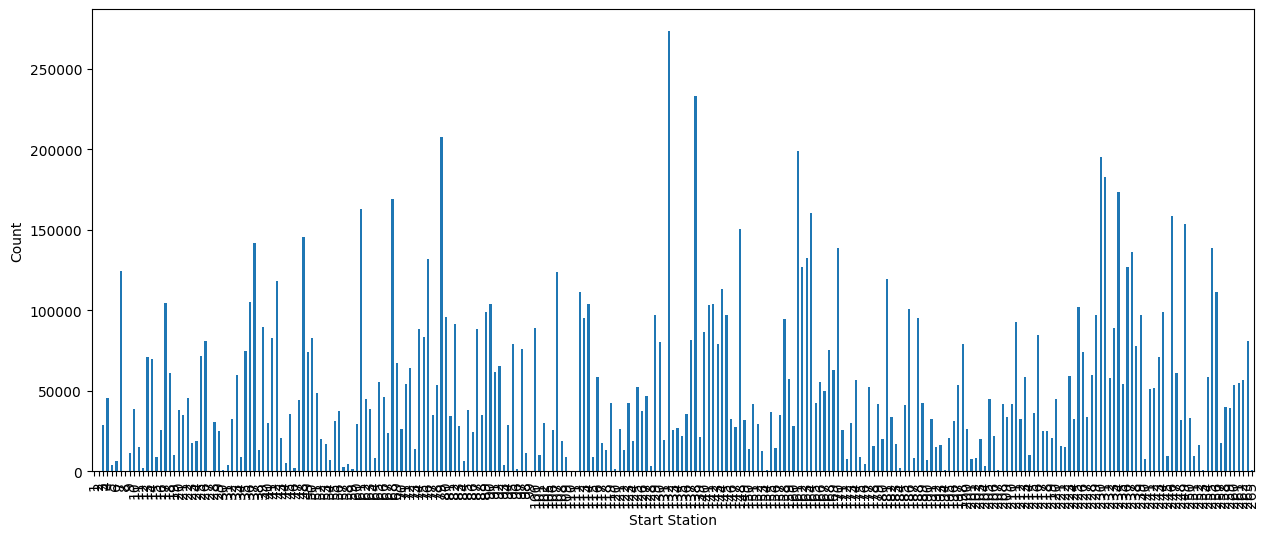

In [70]:
plt.figure(figsize=(15,6))
df['Pickup'].value_counts(sort=False).sort_index().plot(kind='bar')
plt.xlabel("Start Station")
plt.ylabel("Count")
plt.show()

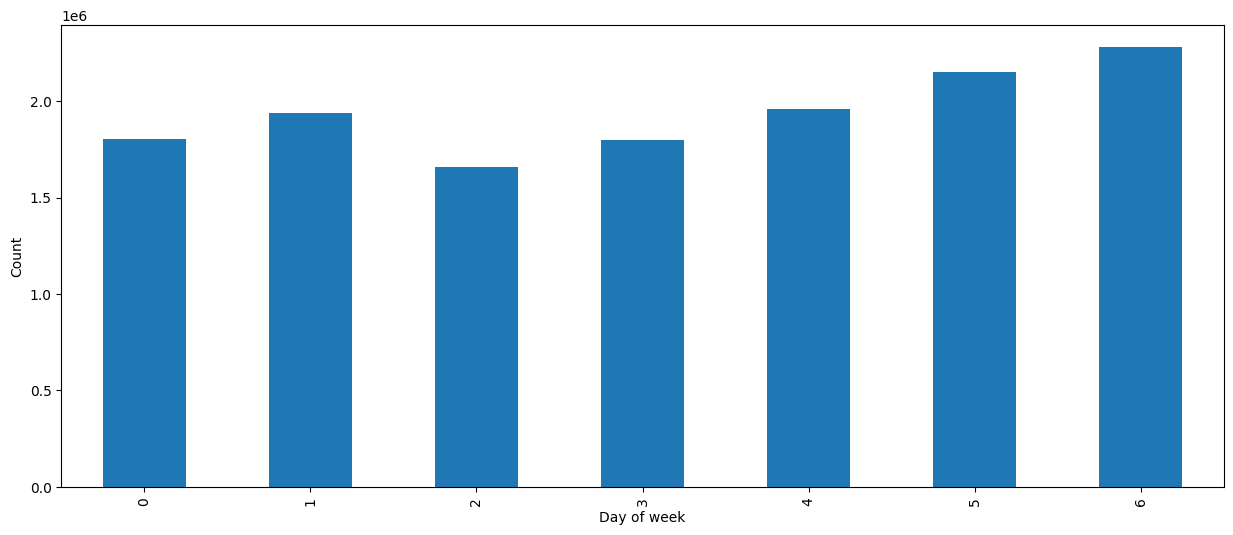

In [71]:
plt.figure(figsize=(15,6))
df['started_at'].dt.dayofweek.value_counts(sort=False).sort_index().plot(kind='bar')
plt.xlabel("Day of week")
plt.ylabel("Count")
plt.show()

# Predicting Start Points

In [73]:
max(df['Pickup'])

265

In [76]:
features = ['time_sin','time_cos','day_sin','day_cos']
targets = ['Pickup']

In [77]:
from sklearn.model_selection import train_test_split

In [80]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[targets], test_size=0.2, random_state=42)

In [81]:
from sklearn.preprocessing import StandardScaler

In [82]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [83]:
from tensorflow.keras.utils import to_categorical

In [85]:
y_train = y_train.values.flatten()
y_test = y_test.values.flatten()

In [89]:
X_train.shape

(10869631, 4)

In [93]:
y_train = np.array(y_train).astype(int)
y_test = np.array(y_test).astype(int)

In [ ]:
y_train = to_categorical(y_train, 266)
y_test = to_categorical(y_test, 266)

In [40]:
model = tf.keras.Sequential()

# Input layer
model.add(tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]))

# Hidden layers
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))

# Output layer (assuming 'n' distinct starting points to predict)
model.add(tf.keras.layers.Dense(265, activation='softmax'))

/Users/mridulverma/PycharmProjects/ridesharing-optimization/venv/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [41]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 265)            │         8,745 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,145 (43.54 KB)

 Trainable params: 11,145 (43.54 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
model.compile(optimizer='adam',metrics=['accuracy'],loss='categorical_crossentropy')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stopping])
model.save('model.keras')

Epoch 1/10


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 1), output.shape=(None, 265)

In [ ]:
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model = tf.keras.models.load_model('model.keras')

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Predicing End Points

In [ ]:
features = ['start_lat','start_lng']
targets = ['end_lat','end_lng']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[targets], test_size=0.2, random_state=42)

In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],),
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(2)
])

In [ ]:
model2.compile(optimizer='adam',metrics=['accuracy'],loss='mse')
model2.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test))

In [ ]:
score = model2.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])